<h1> Ingeniería de atributos y selección de variables</h1>
<p> Sergio Rios Gomez

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pandas_profiling
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

from sklearn.decomposition import PCA 
from sklearn.decomposition import IncrementalPCA

from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  train_test_split

In [2]:
df = pd.read_csv('C:/Users/chech/PC Febrero 2023/CoderHouse/Data Scients/proyectoCoder/finalProject/data/movDic.csv')

C:\Users\chech\AppData\Local\Temp\ipykernel_19936\474200707.py:1: DtypeWarning: Columns (29,34,35,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:/Users/chech/PC Febrero 2023/CoderHouse/Data Scients/proyectoCoder/finalProject/data/movDic.csv')


<p> Reduccoón de dataset, eliminando las variables con mayor cantidad de valores nulos.

In [3]:
df_1 = df[['ID. Grupo','Nombre Grupo', 'ID. Origen', 'Nombre Origen', 'ID. Canal', 'Nombre Canal', 'ID. Terminal', 'Nombre Terminal', 'ID. Transaccion','Nombre Transaccion',
           'Error','Nombre Error', 'Valor','Fecha Transaccion', 'Codigo Entidad Orgien','Cooperativa Terminal','Serial Terminal',
           'Tipo Documento','Documento']]

# Data wrangling: Las transacciones de consulta, registrar valor 0 (cero) en la columna "Valor"
df_1.loc[df_1['Nombre Transaccion'].str.contains('Consul'), 'Valor'] = 0

<h1> Feature Engineering </h1>

<p> Actualizar los valores de la columna "Valor", para que las transacciones que presentaron error y no se realizaron, el dato en la columna Valor sea = 0. En los datos originales viene con el valor en $ COP, dejar esta columna como esta, implica errores al momento de querer hacer calculos posteriores, pues mostraría valores que en realdad no se transaron.

In [4]:
df_1.loc[df_1['Nombre Error'] != 'Exito', 'Valor'] = 0

<h3> 1° variable sintetica, clasificación de la Transacción </h3>
<p> Debido al rango tan amplio que tiene la variable "Valor" (min = $ 0 y max = $ 125.00.00.000), se realiza la creación de una variable sintetica, esta nueva variable (Feature), busca segmentar en grupos las transacciones según el Valor.

In [5]:
def rangos(valor):
    if valor > 100000000:
        return '+ 100 m'
    elif valor > 50000000 and valor <= 100000000:
        return '50 m-100 m'
    elif valor > 20000000 and valor <= 50000000:
        return '20 m-50 m'
    elif valor > 5000000 and valor <= 20000000:
        return '5 m-20 m'
    elif valor > 1000000 and valor <= 5000000:
        return '1 m-5 m'
    elif valor > 200000 and valor <= 1000000:
        return '200-1 m'
    elif valor > 50000 and valor <= 200000:
        return '50-200'
    elif valor > 10000 and valor <= 50000:
        return '10-50'
    elif valor > 1 and valor <= 10000:
        return '1-10'
    else:
        return 'Cero'
df_1['NombreRango'] = df_1['Valor'].apply(rangos)

C:\Users\chech\AppData\Local\Temp\ipykernel_19936\2927994612.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['NombreRango'] = df_1['Valor'].apply(rangos)


<h3> 2° Variable sintetica, Tipo transacción </h3>
<p> Un elemento importante a considerar en el modelo es el tipo de transacción, es decir si las transacciones fueron internas (Movimientos en la misma entidad) o externas (Movimiento entre entidades diferentes). Se proceder a crear una nueva variable sintetica llamada "TipoTrx", Este nuevo feature tendrá dos posibles valores interna/Externa.    

In [6]:
# Convertir la columna "Codigo Entidad Orgien" a tipo de dato object
df_1["Codigo Entidad Orgien"] = df_1["Codigo Entidad Orgien"].astype(str)

# Crear la nueva columna "TipoTrx" y clasificar la transacción como interna o externa.
df_1["TipoTrx"] = np.where(df_1["Codigo Entidad Orgien"] == df_1["Cooperativa Terminal"], "Interna", "Externa")

# Eliminar las filas con valores NA en la columna "Documento"
df_1 = df_1.dropna(subset=["Documento"])

# Convertir la columna "Documento" a tipo de dato int64
df_1["Documento"] = df_1["Documento"].astype(int)

C:\Users\chech\AppData\Local\Temp\ipykernel_19936\1203176889.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1["Codigo Entidad Orgien"] = df_1["Codigo Entidad Orgien"].astype(str)
C:\Users\chech\AppData\Local\Temp\ipykernel_19936\1203176889.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1["TipoTrx"] = np.where(df_1["Codigo Entidad Orgien"] == df_1["Cooperativa Terminal"], "Interna", "Externa")


<h3> 3° Variable sintetica: Frecuencia del usuario </h3>
<p> Otra Feature que podría aportar valor al modelo, es conocer la cantidad de veces que un mismo usuario realiza transacciónes. Para esto se procede a crear una nueva variable llamada "Frecuencia Usu".

In [7]:
# Obtener la frecuencia de cada valor en la columna "Documento"
frecuencia_documentos = df_1["Documento"].value_counts()

# Crear la nueva columna "Frecuencia Usu" basada en la frecuencia de documentos
df_1["Frecuencia Usu"] = df_1["Documento"].map(frecuencia_documentos)

<h3> 4° Variable sintetica: Estado de la trasacción - Exito/Error </h3>
<p> Se crea una variable la cual será una variable binaria donde se clasifique la transacción como exito = 1 o error = 0

In [8]:
# Función para asignar valores en función de la columna "Error"
def asignar_exito(row):
    if row["Error"] == 0 or row["Error"] == 900:
        return 1
    else:
        return 0
df_1["Exito1-0"] = df_1.apply(asignar_exito, axis=1)

In [9]:
# Reducción de las Features del modelo.
df_2 = df_1[['ID. Grupo', 'ID. Origen', 'ID. Canal','Nombre Canal','ID. Terminal', 'ID. Transaccion','Nombre Transaccion','Error','Nombre Error',
             'Valor','Fecha Transaccion', 'Codigo Entidad Orgien','Tipo Documento','Documento', 'NombreRango','TipoTrx', 'Frecuencia Usu', 'Exito1-0']]

<h1> EDA: </h1>
<p> Grafica de la variable sintetica "NombreRango".

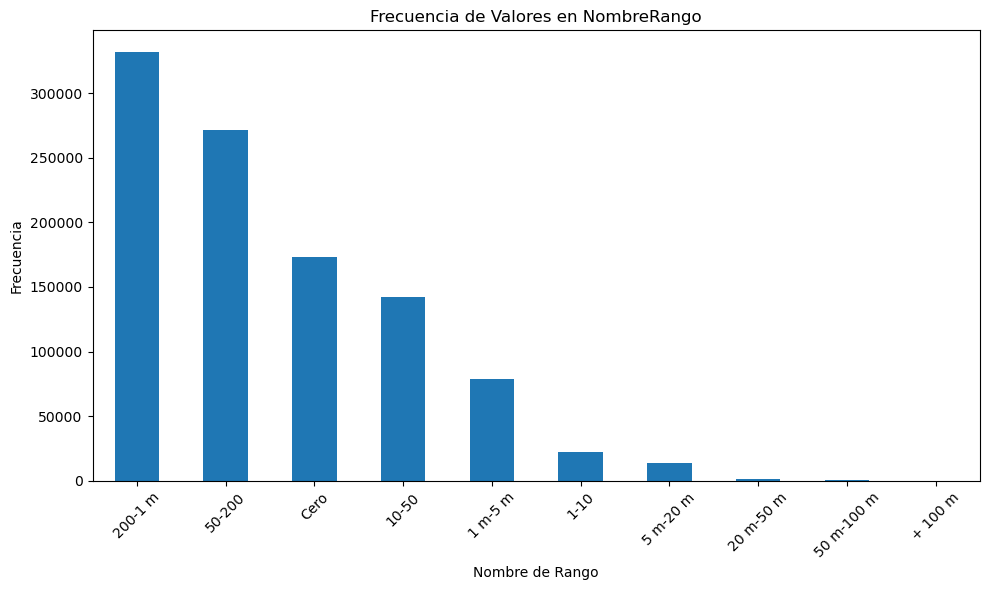

In [11]:
# Obtener la frecuencia de cada valor en la columna "NombreRango"
frecuencia_rangos = df_2["NombreRango"].value_counts()

plt.figure(figsize=(10, 6)) 
frecuencia_rangos.plot(kind="bar") 
plt.title("Frecuencia de Valores en NombreRango")  
plt.xlabel("Nombre de Rango") 
plt.ylabel("Frecuencia") 
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.show() 

<p> Grafica con los valores de la variable sintetica "Tipo de Transacción"

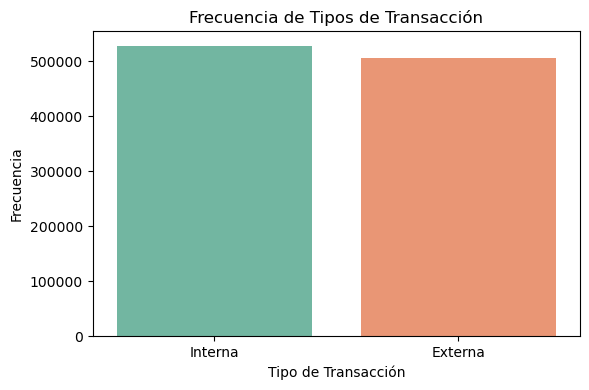

In [12]:
# Crear el gráfico de conteo usando seaborn
plt.figure(figsize=(6, 4))
sns.countplot(data=df_2, x="TipoTrx", palette="Set2")
plt.title("Frecuencia de Tipos de Transacción")
plt.xlabel("Tipo de Transacción")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

<p> Tabla que muestra "Valores únicos" La cantidad de veces que un usuario ha transado en la red. "Frecuencia" la cantidad de usuarios que transaron el numero de veces descrito en la columna "Valores únicos" y "%" es el valor porcentual de la frecuencia con respecto al total.

In [22]:
# Obtener la frecuencia de cada valor único en la columna "Grafica variable"
frecuencia_valores = df_2["Frecuencia Usu"].value_counts()

# Crear un nuevo DataFrame con los valores únicos y su frecuencia
tabla_frecuencia = pd.DataFrame({'Valores únicos': frecuencia_valores.index, 'Frecuencia': frecuencia_valores.values})

# Ordenar el DataFrame por frecuencia descendente
tabla_frecuencia = tabla_frecuencia.sort_values(by='Frecuencia', ascending=False)

# Calcular y agregar la columna de porcentaje
total_registros = len(df_2)
tabla_frecuencia['%'] = (tabla_frecuencia['Frecuencia'] / total_registros) * 100
tabla_frecuencia

,Valores únicos,Frecuencia,%
0,2,58838,5.686259
1,3,57849,5.590680
2,4,54612,5.277848
3,1,52761,5.098962
4,5,51255,4.953418
...,...,...,...
127,114,114,0.011017
128,103,103,0.009954
129,100,100,0.009664
130,84,84,0.008118


<p> Grafica de la variable sintetica "Exito1-0", donde se ve el valor porcentual de las transacciones exitosas o con error.

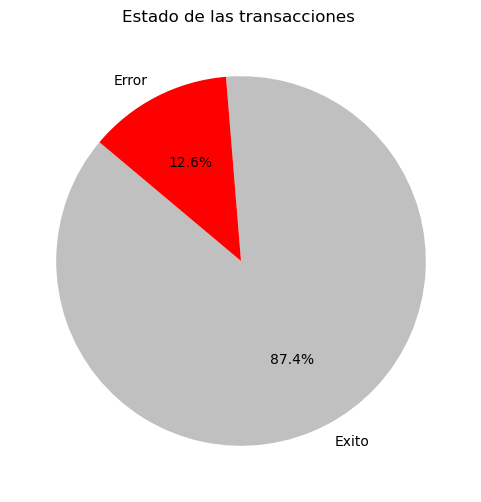

In [23]:
suma_valores = df_2["Exito1-0"].value_counts()

# Crear la gráfica de torta
plt.figure(figsize=(6, 6))
plt.pie(suma_valores, labels=["Exito", "Error"], autopct='%1.1f%%', colors=['silver', 'red'], startangle=140)

plt.title("Estado de las transacciones ")

plt.show()

<h1> Aplicación del Análisis de Componentes Principales (PCA) en la Predicción Transaccional </h1>

In [25]:
df_3 = df_2[['ID. Grupo', 'ID. Origen', 'ID. Canal', 'ID. Terminal', 'ID. Transaccion', 'Valor', 'Documento','NombreRango', 'TipoTrx', 'Frecuencia Usu', 'Exito1-0']]
df_4 = df_3.copy()

<h4> Implementación de Label Encoding,  </h4>

In [27]:
label_encoder = LabelEncoder()

df_4["ID. Grupo"] = label_encoder.fit_transform(df_4["ID. Grupo"])

df_4["ID. Terminal"] = label_encoder.fit_transform(df_4["ID. Terminal"])

df_4["ID. Transaccion"] = label_encoder.fit_transform(df_4["ID. Transaccion"])

df_4["NombreRango"] = label_encoder.fit_transform(df_4["NombreRango"])

df_4["TipoTrx"] = label_encoder.fit_transform(df_4["TipoTrx"])

In [30]:
df_4.sample(5)

,ID. Grupo,ID. Origen,ID. Canal,ID. Terminal,ID. Transaccion,Valor,Documento,NombreRango,TipoTrx,Frecuencia Usu,Exito1-0
100807,0,3,1,3,4,600000,1018482694,5,0,14,1
380545,0,3,1,2,3,0,37182588,9,1,3,0
557681,0,6,0,0,3,500000,88142180,5,1,1,1
1045032,0,6,6,9,3,500000,1088285614,5,1,19,1
878703,0,1,2,7,0,119800,88251869,8,0,42,1


In [33]:
df_features = df_4.drop(['Exito1-0'], axis=1)
df_target = df_4['Exito1-0']

df_features = StandardScaler().fit_transform(df_features)

X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.3, random_state=42)

In [34]:
print(df_4.shape)
print(X_train.shape)
print(y_train.shape)

(1034740, 11)
(724318, 10)
(724318,)


In [35]:
pca = PCA(n_components=3)
pca.fit(X_train)

ipca = IncrementalPCA(n_components=3, batch_size=10)
ipca.fit(X_train)

IncrementalPCA(batch_size=10, n_components=3)

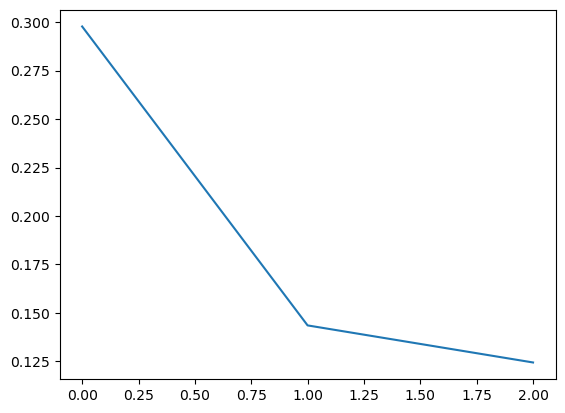

In [36]:
plt.plot(range(len(pca.explained_variance_)), pca.explained_variance_ratio_)
plt.show()

In [38]:
logistic = LogisticRegression(solver='lbfgs')

dt_train = pca.transform(X_train)
dt_test = pca.transform(X_test)
logistic.fit(dt_train,y_train)
print("SCORE PCA: ", logistic.score(dt_test, y_test))

SCORE PCA:  0.87376216891844


<p> El presente modelo, posee un SCORE igual al modelo ejecutado sin las variables sinteticas, se procede a realizar un analisis de correlaciones para entender como se correlacionan con las features originales las variables sinteticas. Se esperaba un mejor SCORE con las nuevas variable. Con la grafica de las correlaciones se procederá a crear nuevas variables para medir si el modelo presenta mejoras.

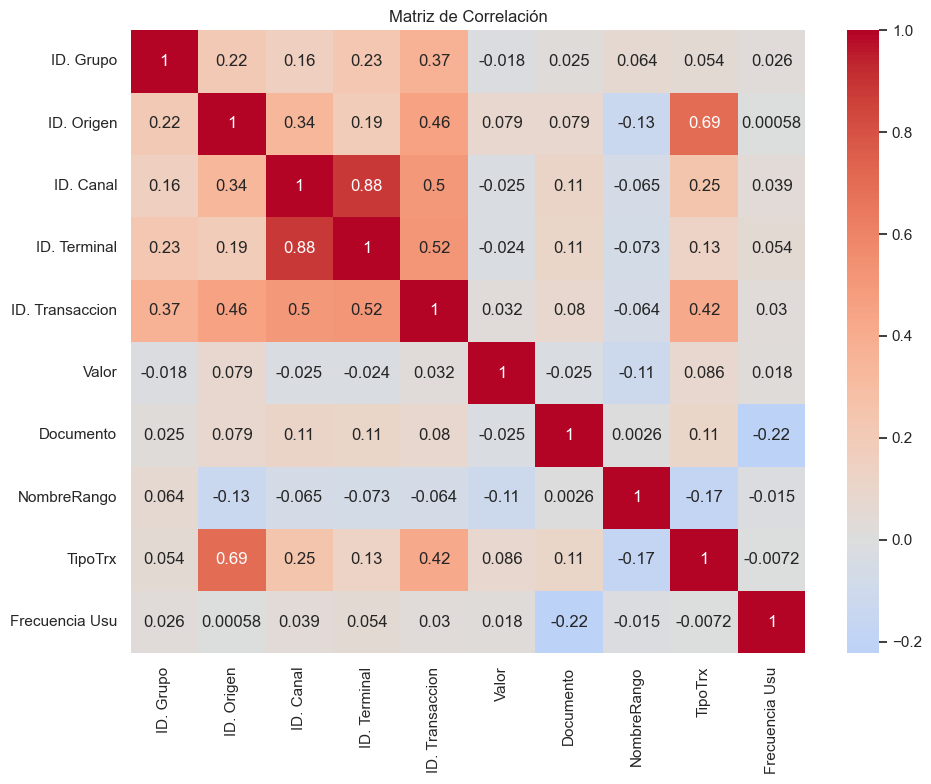

In [48]:
df_4Gra = df_4.drop(['Exito1-0'], axis=1)

# Calcular la matriz de correlación
correlation_matrix = df_4Gra.corr()

# Crear un mapa de calor (heatmap) de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Matriz de Correlación")
plt.tight_layout()
plt.show()

<li> La variable sintetica "Nombre Rango" NO tiene una relación importante con el resto de las variables
<li> Las variable "TipoTrx, es la variable sintetica con relación más alta. 
<li> Frecuencia Usu, no tiene mayor aporte en el performance del modelo.

<p> El desafio del modelo es buscar nuevos features y nuevos algoritmos que aporten al rendimiento del modelo y a aumentar su SCORE.